In [1]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Importacion y preprocesamiento de datos

In [2]:
direccion=r"C:/Users/Guille/Desktop/Clustering_Guille/dataset_csv/Metropolitano142.csv"
df = pd.DataFrame()
df = pd.read_csv(direccion)

df["Hora"]=pd.to_datetime(df["Hora"],  format='%Y-%m-%d %H:%M:%S',dayfirst=True)
df.rename(columns={"Hora": "Fecha"}, inplace=True)
df['Hora'] = df['Fecha'].dt.hour

# cortamos el rango que no nos sirve
df=df[df["Fecha"]>'2022-01-07 23:00:00']
extra_rows = len(df) % 24
if extra_rows != 0:
    df = df.iloc[:-extra_rows]

# hallamos los valores vacios y los llenamos con el valor promedio de su columna
nan_columns = df.columns[df.isnull().any()].tolist()
df[nan_columns] = df[nan_columns].fillna(df[nan_columns].mean())

data=df.copy()
data["Fecha"]=pd.to_datetime(data["Fecha"],dayfirst=True)
data = data.set_index('Fecha')
data.pop(data.columns.values[-1])

data # 121 usuarios, 552 horas = 23 días

,171,170,169,168,167,166,165,164,163,162,...,60,59,58,57,56,55,54,53,52,51
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-08 00:00:00,2.656,1.936,3.420,0.332,2.402,3.626000,2.994,1.340,2.222000,4.986,...,0.924,1.568,1.882,3.208,0.112,1.920,1.596,2.594,0.922,2.852
2022-01-08 01:00:00,2.204,1.504,3.680,0.324,2.998,3.024000,4.178,1.262,2.044000,3.656,...,0.242,1.460,1.942,2.864,0.112,1.418,1.722,2.018,2.572,2.748
2022-01-08 02:00:00,2.188,1.452,2.676,0.674,2.772,2.758000,3.858,0.956,1.766000,3.268,...,0.624,0.202,1.922,2.602,0.108,1.024,1.548,1.992,2.798,2.572
2022-01-08 03:00:00,1.924,1.398,2.508,0.366,5.884,1.028000,3.418,0.194,3.506000,3.308,...,0.352,0.158,1.850,2.260,0.108,0.988,2.754,1.922,2.418,2.556
2022-01-08 04:00:00,1.796,1.412,2.280,0.320,6.868,0.520000,3.352,0.230,3.122000,4.306,...,0.234,0.086,1.832,1.922,0.106,0.474,2.776,1.898,1.626,1.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30 19:00:00,1.306,1.208,3.300,2.590,0.662,1.797503,0.872,2.014,3.081973,1.572,...,0.070,0.030,2.640,0.746,0.300,2.172,2.618,0.960,0.244,2.678
2022-01-30 20:00:00,0.748,0.796,3.478,3.944,0.712,1.797503,0.724,1.980,3.081973,2.266,...,0.068,0.174,2.404,1.236,0.296,1.812,2.460,1.206,0.200,2.836
2022-01-30 21:00:00,1.760,0.584,3.176,3.120,0.704,1.797503,0.852,1.462,3.081973,3.260,...,0.062,0.794,2.070,0.984,0.288,2.722,2.170,2.958,0.818,2.358


# Variational Mode Decomposition

In [3]:
from sktime.libs.vmdpy import VMD
from scipy.signal import find_peaks

##### La K fue determinado en VMD_K_determination.ipynb

In [4]:
# Diccionario para almacenar los resultados de la VMD de cada usuario
resultados_VMD = {}

# Seleccionar usuarios
usuarios_seleccionados = data.columns[0:121]

# Parámetros de VMD
alpha = 2000     # Penalización de ruido (ajustable)
tau = 0          # Parámetro de tolerancia (0 para VMD estricto)
K = 4            # Número de modos a extraer
DC = 0           # Sin sesgo DC
init = 1         # Inicialización aleatoria
tol = 1e-6       # Tolerancia de convergencia

for usuario in tqdm(usuarios_seleccionados):
    
    signal_usuario = data[usuario].dropna().values  # Extraer la señal y eliminar NaNs
    signal_usuario = np.nan_to_num(signal_usuario)  # Sustituir NaNs por 0 si es necesario

    # Aplicar VMD
    u, u_hat, omega = VMD(signal_usuario, alpha, tau, K, DC, init, tol)

    # Guardar resultados en el diccionario
    resultados_VMD[usuario] = {
        "u": u, 
        "u_hat": u_hat, 
        "omega": omega, 
        "original": signal_usuario
    }

    """ # Habilitar/deshabilitar plots
    
    plt.figure(figsize=(10, 12))
    plt.rcParams.update({'font.size': 21})

    # Subplot 1: Señal original
    plt.subplot(K+1, 1, 1)
    plt.plot(signal_usuario, color='black')
    plt.title(f"Original")

    # Subplots 2 a K+1: Modos VMD
    for i in range(K):
        plt.subplot(K+1, 1, i+2)

        # Encontrar picos y estimar período
        peaks, _ = find_peaks(u[i, :])
        periodos = np.diff(peaks)
        periodo_estimado = np.mean(periodos) if len(periodos) > 0 else np.nan

        plt.plot(u[i, :])
        plt.title(f"Mode {i+1}, Estimated period: {periodo_estimado:.2f}")
    
    plt.suptitle(f'Decomposition for user {usuario}')
    plt.xlabel('Hours')
    plt.tight_layout()
    plt.show()

    """ # Habilitar/deshabilitar plots

# Verificar la estructura del diccionario
print(f"\nUsuarios almacenados en resultados_VMD: {list(resultados_VMD.keys())}")


100%|██████████| 121/121 [00:02<00:00, 57.41it/s]


Usuarios almacenados en resultados_VMD: ['171', '170', '169', '168', '167', '166', '165', '164', '163', '162', '161', '160', '159', '158', '157', '156', '155', '154', '153', '152', '151', '150', '149', '148', '147', '146', '145', '144', '143', '142', '141', '140', '139', '138', '137', '136', '135', '134', '133', '132', '131', '130', '129', '128', '127', '126', '125', '124', '123', '122', '121', '120', '119', '118', '117', '116', '115', '114', '113', '112', '111', '110', '109', '108', '107', '106', '105', '104', '103', '102', '101', '100', '99', '98', '97', '96', '95', '94', '93', '92', '91', '90', '89', '88', '87', '86', '85', '84', '83', '82', '81', '80', '79', '78', '77', '76', '75', '74', '73', '72', '71', '70', '69', '68', '67', '66', '65', '64', '63', '62', '61', '60', '59', '58', '57', '56', '55', '54', '53', '52', '51']


### Reconstrucción en dominio del tiempo

In [5]:
# Modos a utilizar para la reconstrucción
modos_a_usar = [0, 1, 2]  # Puedes cambiarlo según lo que consideres ruido o señal útil

reconstruidas_dict = {}

# Número de usuarios a graficar
usuarios = list(resultados_VMD.keys())  
num_usuarios = len(usuarios)

"""
# Definir el tamaño de la cuadrícula de subplots
filas = int(np.ceil(np.sqrt(num_usuarios)))  # Número de filas en la cuadrícula
columnas = int(np.ceil(num_usuarios / filas))  # Número de columnas

fig, axes = plt.subplots(filas, columnas, figsize=(15, 10))
axes = axes.flatten()  # Asegura que podamos iterar sobre los ejes
"""
# Iterar sobre cada usuario y su respectivo subplot
for i, usuario in enumerate(usuarios):
    datos = resultados_VMD[usuario]
    u = datos["u"]  # Matriz de modos
    signal_original = datos["original"]  # Señal original del usuario

    # Reconstrucción de la señal usando solo los modos seleccionados
    reconstruida = np.sum(u[modos_a_usar, :], axis=0)
    reconstruidas_dict[usuario] = reconstruida
"""
    # Graficar en el subplot correspondiente
    ax = axes[i]
    ax.plot(signal_original, label="original", color='black', linestyle="dashed")
    ax.plot(reconstruida, label="reconstruida", color='red', alpha=0.7)
    ax.set_title(f"Usuario {usuario}")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Consumo Energético (KWh)")
    #ax.legend()
    ax.grid(True)

# Ajustar diseño para evitar superposición
plt.tight_layout()
plt.show()"
"""

'\n    # Graficar en el subplot correspondiente\n    ax = axes[i]\n    ax.plot(signal_original, label="original", color=\'black\', linestyle="dashed")\n    ax.plot(reconstruida, label="reconstruida", color=\'red\', alpha=0.7)\n    ax.set_title(f"Usuario {usuario}")\n    ax.set_xlabel("Tiempo")\n    ax.set_ylabel("Consumo Energético (KWh)")\n    #ax.legend()\n    ax.grid(True)\n\n# Ajustar diseño para evitar superposición\nplt.tight_layout()\nplt.show()"\n'

Aquí es donde se crea el dataframe df_promedio aplicando el groupby("hora").mean()

Si los datos poseen una periodicidad importante mostrado por el LSP en 24 horas, creo que está justificado este agrupamiento promedio en 24 horas.

In [8]:
# Crear un DataFrame con las señales reconstruidas
df_reconstruidas = pd.DataFrame(reconstruidas_dict, index=data.index)
# Cambiar el índice para que vaya de 0 a la cantidad total de filas - 1
df_reconstruidas.index = range(len(df_reconstruidas))
# Renombrar el índice a 'hora'
df_reconstruidas.index.name = 'hora'

df_reconstruidas
#df_reconstruidas = df_reconstruidas.drop(['208','195'], axis=1)
"""
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Aplicar la normalización
df_reconstruidas = pd.DataFrame(scaler.fit_transform(df_reconstruidas), columns=df_reconstruidas.columns, index=df_reconstruidas.index)
"""
#""" # Habilitar/deshabilitar groupby(hora).mean()
# Crear una columna de hora correctamente (sin duplicar en el índice)
df_reconstruidas = df_reconstruidas.reset_index()
df_reconstruidas["hora"] = df_reconstruidas["hora"] % 24  

# Agrupar por la hora y calcular el promedio de consumo para cada usuario
df_promedio = df_reconstruidas.groupby("hora").mean()

# Restaurar el nombre del índice
df_promedio.index.name = "hora"

df_promedio
#""" # Habilitar/deshabilitar groupby(hora).mean()

,171,170,169,168,167,166,165,164,163,162,...,60,59,58,57,56,55,54,53,52,51
hora,,,,,,,,,,,,,,,,,,,,,
0,2.363583,1.202343,2.551832,1.303664,3.123110,1.612123,2.602476,1.360906,2.526084,3.459263,...,0.707573,0.713006,2.610572,1.645131,0.273755,1.218480,2.320860,1.931166,0.947233,2.276010
1,2.061142,1.229531,2.413726,1.256316,3.038419,1.369443,2.590894,1.403888,2.772380,3.505744,...,0.712114,0.623049,2.374212,1.568424,0.267246,1.113807,2.418485,1.830095,1.344131,2.496280
2,1.794495,1.183404,2.368652,1.240605,2.894952,1.211889,2.442092,1.542018,3.044165,3.624193,...,0.644494,0.539543,2.145260,1.461191,0.261247,0.991067,2.427271,1.820016,1.634543,2.596763
3,1.688113,1.113006,2.312182,1.241247,2.711892,1.138535,2.227178,1.789336,3.291047,3.803772,...,0.557297,0.432126,2.023813,1.366650,0.256742,0.873687,2.400688,1.617459,1.680902,2.575074
4,1.732143,1.054618,2.185811,1.247278,2.495360,1.147251,2.036304,2.146216,3.446085,4.000317,...,0.492972,0.367757,1.999428,1.267797,0.252305,0.775218,2.384603,1.634708,1.437136,2.450405
5,1.844845,1.010755,2.049164,1.260388,2.301021,1.197121,1.927330,2.618083,3.497038,4.155547,...,0.459489,0.426912,1.985083,1.142399,0.247812,0.702788,2.381068,2.085038,0.990680,2.249720
6,1.941106,0.955699,2.021319,1.281120,2.225515,1.238179,1.899726,3.158135,3.487502,4.229290,...,0.436430,0.564114,1.934679,1.023805,0.245462,0.653313,2.356455,2.321529,0.529113,1.998876
7,1.968335,0.856230,2.179279,1.316397,2.341910,1.247301,1.896654,3.710843,3.431365,4.214082,...,0.394217,0.627581,1.898211,0.959887,0.245468,0.623914,2.276674,1.895432,0.262855,1.737090
8,1.898166,0.701515,2.479051,1.377920,2.658106,1.217626,1.838111,4.235825,3.359417,4.108117,...,0.322007,0.523672,1.976475,0.963280,0.245394,0.611661,2.165433,1.377086,0.298230,1.516189


### Reconstrucción en el dominio de la frecuencia

In [7]:
# Modos a utilizar para la reconstrucción en el dominio de la frecuencia
modos_a_usar = [0, 1, 2]  # Puedes cambiarlo según lo que consideres ruido o señal útil
reconstruidas_frec_dict = {}

# Iterar sobre cada usuario
for i, usuario in enumerate(usuarios):
    datos = resultados_VMD[usuario]
    u_hat = datos["u_hat"]  # Matriz de valores complejos en el dominio de la frecuencia
    omega = datos["omega"]  # Frecuencias angulares de cada componente de u_hat

    # Inicializar una lista para almacenar las magnitudes de u_hat para los modos seleccionados
    magnitudes = []

    # Para cada modo seleccionado (usando los índices en modos_a_usar)
    for mode in modos_a_usar:
        # Extraer el componente complejo de u_hat
        u_hat_mode = u_hat[mode, :]

        # Calcular la magnitud del número complejo u_hat_mode
        magnitude = np.abs(u_hat_mode)

        # Almacenar la magnitud
        magnitudes.append(magnitude)

    # Sumar las magnitudes de los modos seleccionados (no los números complejos, solo las magnitudes)
    reconstruida_frec = np.sum(magnitudes, axis=0)

    # Guardar la reconstrucción en el diccionario
    reconstruidas_frec_dict[usuario] = reconstruida_frec

# Convertir el diccionario en un DataFrame para tener omega como índice
df_reconstruidas_frec = pd.DataFrame(reconstruidas_frec_dict, index=omega[0])  # omega[0] tiene la frecuencia angular

# Renombrar la columna de frecuencias como "omega"
df_reconstruidas_frec.columns.name = "omega"

df_reconstruidas_frec = df_reconstruidas_frec.drop(['144'], axis=1)

df_reconstruidas_frec


omega,171,170,169,168,167,166,165,164,163,162,...,60,59,58,57,56,55,54,53,52,51
0.000,0.386001,0.535864,0.313483,3.915939,3.555208,0.149457,2.177972,1.675287,1.400855,0.561969,...,0.406036,0.053787,1.325448,1.068968,0.130379,0.192642,0.365662,0.159484,1.533485,0.322748
0.125,0.867766,0.984900,0.424248,0.763531,0.919519,1.214108,1.804688,0.787351,2.429983,1.030060,...,0.048036,0.169291,0.319802,0.890559,0.182819,1.136588,0.468064,0.630582,0.508834,1.166810
0.250,0.263693,0.142380,0.184082,0.378170,3.138227,0.539108,0.505192,0.955884,1.341798,0.808964,...,0.314749,0.919080,0.173958,0.251697,0.015324,0.513199,0.244735,0.883145,1.183995,0.141376
0.375,0.774046,0.705374,0.467657,1.500167,0.628775,0.732989,0.411246,0.811786,1.304327,0.313699,...,0.272510,0.198000,0.964040,0.515679,0.029414,0.414990,0.136988,0.701111,0.661489,0.577124


Si el ruido está en los muestreos desconocidos de las señales de consumo en el tiempo (desplazamientos aleatorios).
No está entonces en la fase el ruído? Habría que ver cuál modo posee mayor dispersión de fase, o sea si las fases de u_hat se alejan entre sí.

In [8]:
modos_a_usar = [0, 1, 2]  # Puedes cambiarlo según lo que consideres ruido o señal útil
reconstruidas_fase_dict = {}

# Iterar sobre cada usuario
for i, usuario in enumerate(usuarios):
    datos = resultados_VMD[usuario]
    u_hat = datos["u_hat"]  # Matriz de valores complejos en el dominio de la frecuencia
    omega = datos["omega"]  # Frecuencias angulares de cada componente de u_hat

    fases = []

    for mode in modos_a_usar:

        u_hat_mode = u_hat[mode, :]

        fase = np.angle(u_hat_mode, deg=True)

        fases.append(fase)

    reconstruida_fase = np.sum(fases, axis=0)

    reconstruidas_fase_dict[usuario] = reconstruida_fase

# Convertir el diccionario en un DataFrame para tener omega como índice
df_reconstruidas_fase = pd.DataFrame(reconstruidas_fase_dict, index=omega[0])  # omega[0] tiene la frecuencia angular

df_reconstruidas_fase.columns.name = "omega"

df_reconstruidas_fase = df_reconstruidas_fase.drop(['144'], axis=1)

df_reconstruidas_fase

desviacion_estandar = []
for i in range(K):
    desviacion_estandar.append(df_reconstruidas_fase.iloc[i].std())
print(desviacion_estandar)


[232.48213853809054, 183.45401303355894, 193.99567118480414, 185.68636545377026]


De los 4 modos obtenidos, exceptuando el modo 0 (base de la señal), el modo 2 es el que más dispersión de fase presenta.

# K-Means Clusters

In [9]:
### EMPIEZA EL CLUSTERING ###
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

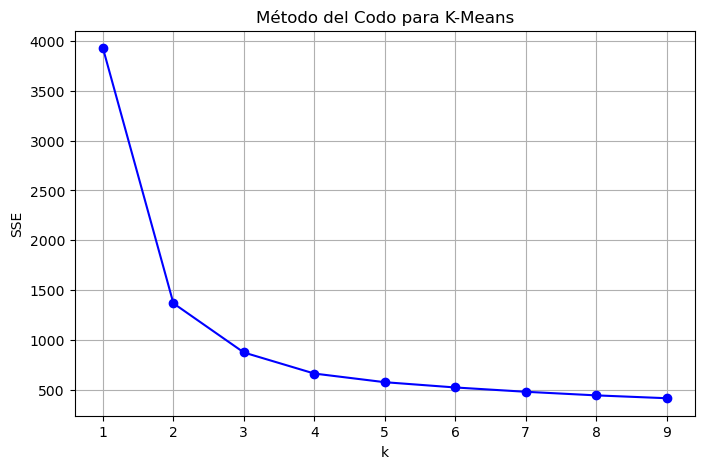

In [10]:
df_pivot = df_promedio.pivot_table(index=None, columns='hora', values=df_reconstruidas.columns[1:])
#df_pivot = pd.DataFrame(df_reconstruidas_frec).T
# Definir el rango de clusters a probar
k_values = range(1, 10)  # Probamos de 1 a 20 clusters

# Usar solo las columnas de df_reconstruidas, donde cada columna es un usuario
X = df_pivot.values  # Las señales reconstruidas de cada usuario

# Lista para almacenar la suma de los errores cuadráticos (SSE)
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # La inercia es la suma de los errores cuadráticos

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, 'bo-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()


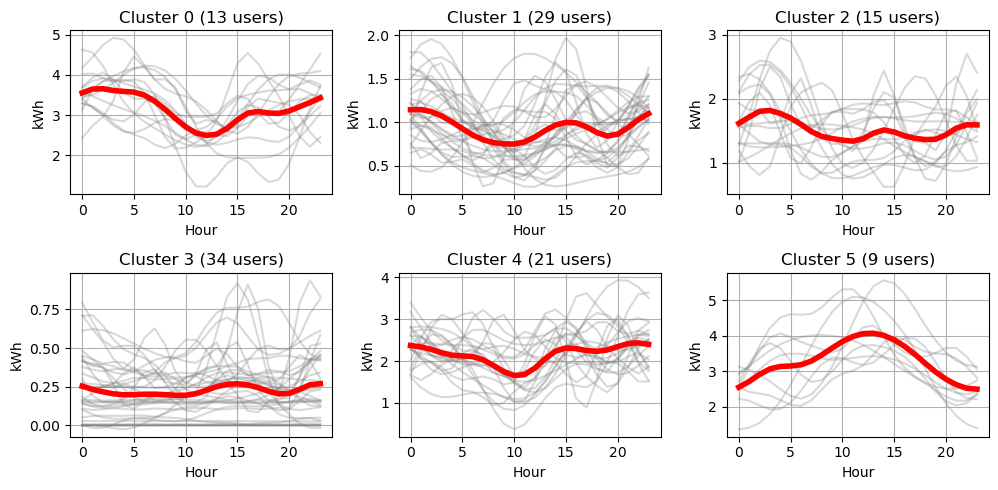

In [20]:
# Pivotar el dataframe para tener las horas en las columnas y NIS (usuarios) como filas
df_pivot = df_promedio.pivot_table(index=None, columns='hora', values=df_reconstruidas.columns[1:])
#df_pivot = pd.DataFrame(df_reconstruidas_frec).T

X = df_pivot.values  # Datos de las señales reconstruidas

# Número de clusters obtenido previamente
num_clusters = 6

# Aplicar K-Means sobre estas curvas de 24 dimensiones
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_pivot['cluster'] = kmeans.fit_predict(X)  # Asignar los clusters a los usuarios

# Paso 2: Graficar todas las curvas en gris y los promedios de cada cluster en rojo
fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # Ajusta según el número de clusters

for i, ax in enumerate(axes.flatten()):
    cluster_data = df_pivot[df_pivot['cluster'] == i].drop(columns='cluster')
    cluster_size = len(cluster_data)  # Cantidad de muestras en el cluster

    # Graficar todas las curvas de usuarios en GRIS
    for _, row in cluster_data.iterrows():
        ax.plot(row.index, row.values, color='gray', alpha=0.3)

    # Graficar la curva promedio del cluster en ROJO
    cluster_mean = cluster_data.mean()
    ax.plot(cluster_mean.index, cluster_mean.values, color='red', linewidth=4)

    # Graficar la curva centroide del cluster en AZUL
    #centroide = kmeans.cluster_centers_[i]
    #ax.plot(cluster_mean.index, centroide, color='blue', linestyle='--', linewidth=3, label="Centroide del Cluster")

    # Configuración de cada subplot con la cantidad de muestras
    ax.set_title(f'Cluster {i} ({cluster_size} users)')
    ax.set_xlabel('Hour')
    ax.set_ylabel('kWh')
    #ax.set_xlim(0, 23)
    #ax.set_ylim(0, 4.5)
    ax.grid(True)

plt.tight_layout()
plt.show()


In [12]:
clusters_info = {}

for i in range(num_clusters):
    users_in_cluster = df_pivot[df_pivot['cluster'] == i].index.tolist()
    clusters_info[f'Cluster {i}'] = users_in_cluster

# Mostrar los usuarios por cluster
for cluster, users in clusters_info.items():
    print(f"{cluster}: {users}")

Cluster 0: ['121', '134', '142', '144', '145', '150', '161', '162', '62', '63', '64', '69', '85']
Cluster 1: ['102', '105', '111', '113', '124', '127', '129', '130', '132', '137', '147', '151', '155', '157', '159', '170', '52', '55', '57', '65', '66', '68', '73', '77', '83', '90', '92', '96', '99']
Cluster 2: ['101', '107', '108', '109', '131', '141', '154', '158', '168', '51', '53', '61', '72', '74', '94']
Cluster 3: ['100', '103', '106', '110', '114', '115', '116', '117', '118', '119', '120', '122', '123', '125', '133', '135', '152', '153', '160', '56', '59', '60', '67', '71', '75', '78', '80', '84', '87', '88', '89', '93', '95', '98']
Cluster 4: ['112', '126', '128', '136', '140', '143', '146', '149', '156', '165', '166', '171', '54', '58', '70', '76', '79', '81', '82', '86', '91']
Cluster 5: ['104', '138', '139', '148', '163', '164', '167', '169', '97']


In [13]:
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

X = df_pivot.values

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

labels = kmeans.fit_predict(X)

score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.4334


In [ ]:
from sklearn.metrics import calinski_harabasz_score

X = df_pivot.values

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

labels = kmeans.fit_predict(X)

score = calinski_harabasz_score(X, labels)
    
print(f"Calinski-Harabasz Score: {score:.4f}")

Calinski-Harabasz Score: 161.7985


: 